In [1]:
import os, warnings
warnings.simplefilter("ignore")

from fastai.data.external import *
from fastbook import *
from fastai.vision.widgets import *
from dotenv import load_dotenv

In [2]:
key_azure = os.environ.get('AZURE_SEARCH_KEY')
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

## Dog Classifier Notebook
This notebook will be used to **acquire, clean, and label** the dog dataset; then the model will be trained and exported.

In [5]:
wiener_dogs = search_images_bing(key_azure, 'wiener dog')
len(wiener_dogs)

150

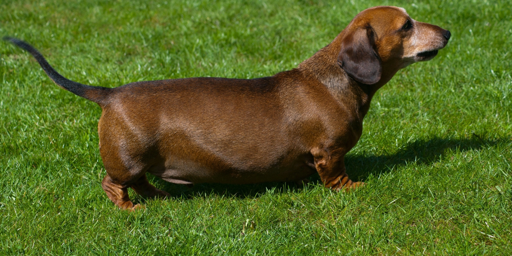

In [6]:
dest_ex = 'images/wiener_dog.jpg'
download_url(wiener_dogs[0]['contentUrl'], dest_ex)

im = Image.open(dest_ex)
im.to_thumb(512, 512)

## Get Images and store them in dogs/label

In [7]:
dog_path = Path('dogs')
dog_classes = 'hot dog','corn dog','wiener dog'

('hot dog', 'corn dog', 'wiener dog')

In [8]:
if not dog_path.exists():
    dog_path.mkdir()
    for label in dog_classes:
        destination = (dog_path/label.replace(' ', "_"))
        destination.mkdir(exist_ok=True)
        results = search_images_bing(key_azure, label)
        download_images(destination, urls=results.attrgot('contentUrl'))

In [9]:
fps =  get_image_files(dog_path)

(#378) [Path('dogs/wiener_dogs/540a4e63-0c34-4f0b-bc49-22cbcf0fe3f4.jpg'),Path('dogs/wiener_dogs/a90dc925-a75a-47b1-acae-fedbd59acd52.jpg'),Path('dogs/wiener_dogs/f5062576-0b50-4a78-8a1f-ed6c732ae1a4.jpg'),Path('dogs/wiener_dogs/50d8a8e8-cec5-43c6-b44c-2350bf4171e9.jpg'),Path('dogs/wiener_dogs/b9797c1a-a210-466a-a5fc-f1acb83f8bb9.jpg'),Path('dogs/wiener_dogs/6b98cf91-984f-4e68-a17b-5858b5f95f39.jpg'),Path('dogs/wiener_dogs/e0cb3b34-0c27-43cc-9d6e-4b64fab3f9b0.jpg'),Path('dogs/wiener_dogs/7b4c0758-8d51-400f-aa3e-35bd9cfaf17b.jpg'),Path('dogs/wiener_dogs/eb50efcc-2dc3-428c-aa9e-fa11b214f6b4.jpg'),Path('dogs/wiener_dogs/6bc5a0ef-6e92-448a-af74-b1a0a0d8862e.png')...]

In [32]:
failed = verify_images(fps)

(#5) [Path('dogs/wiener_dogs/493af45d-80d9-45b6-a7f0-a3ca06857cf0.jpg'),Path('dogs/wiener_dogs/f222f5eb-fa20-407e-892f-0c1ac4718450.jpg'),Path('dogs/wiener_dogs/2594b242-8364-4ced-9033-466649bde55f.jpg'),Path('dogs/corn_dogs/5e3e525d-80b1-4083-9ef1-4d631b962866.jpg'),Path('dogs/hot_dogs/9c9cc56f-8696-4ff7-a3df-5c142a995aab.jpg')]

In [33]:
failed.map(Path.unlink)

(#5) [None,None,None,None,None]

In [10]:
dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=23),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

dls = dogs.dataloaders(dog_path)

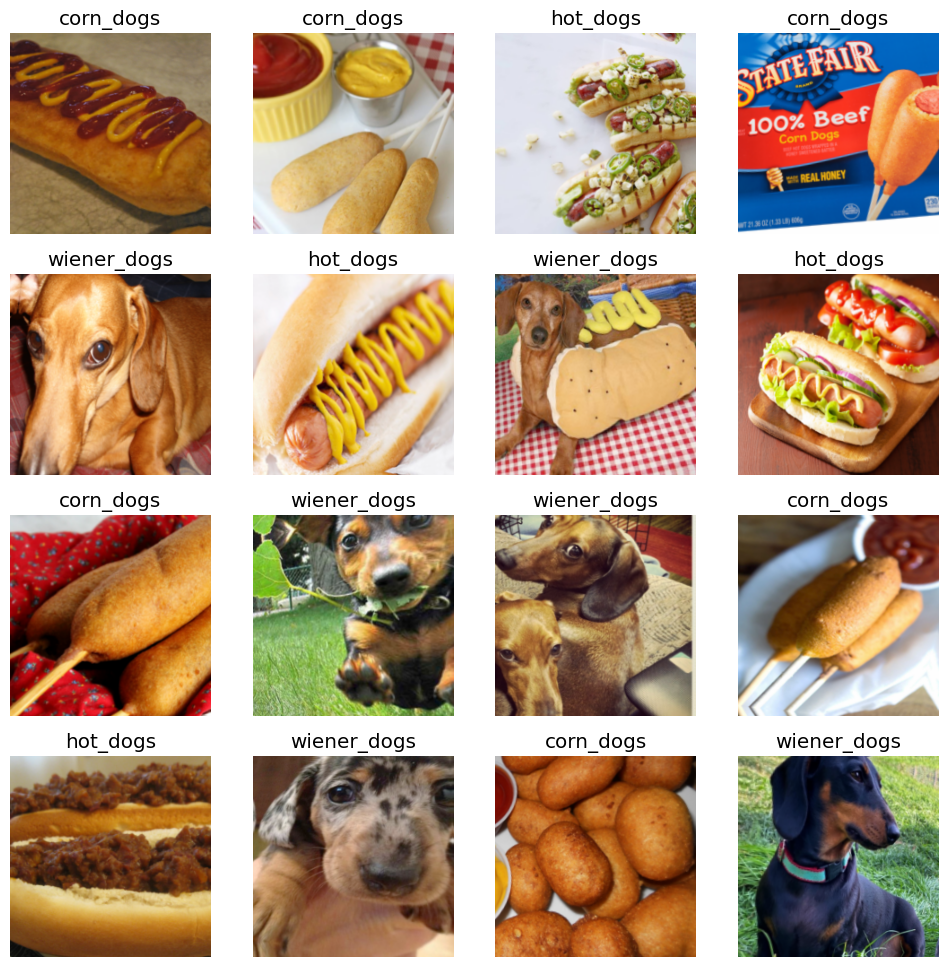

In [11]:
dls.show_batch(max_n=16)

## Begin Model training

In [44]:
learn = vision_learner(dls, resnet18, metrics=[accuracy])
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.386636,0.917198,0.744186,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.358334,0.246772,0.930233,00:05
1,0.272423,0.095649,0.965116,00:05
2,0.211567,0.061774,0.988372,00:05
3,0.179914,0.053425,0.988372,00:05


## Accuracy is very good. Time to investigate inference and clean data

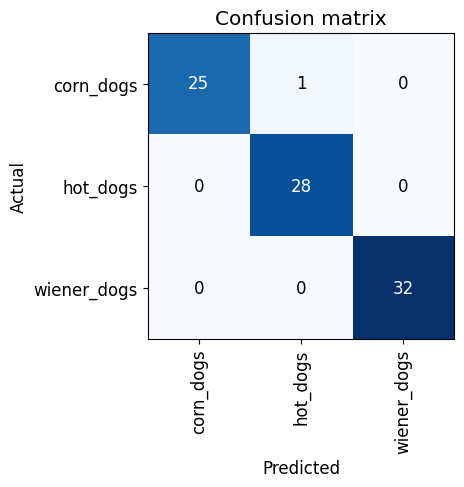

In [45]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Sometimes we see a corn dog and think its a hot dog... Not too bad

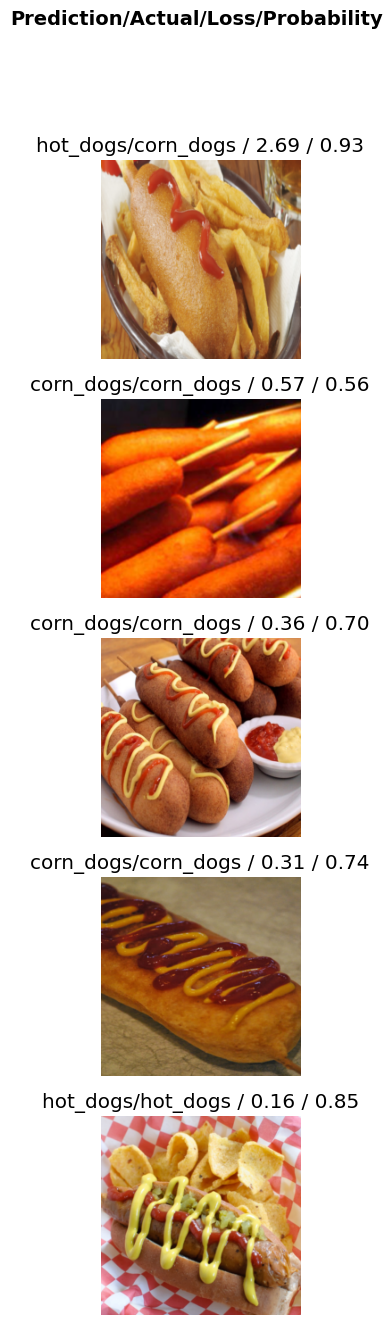

In [46]:
interp.plot_top_losses(5, nrows=5)

## Looks like the hot dog/corn dog missunderstanding should be fixed... On different training cycles I often see the model confused about confusing pictures though, which is a good thing

In [47]:
cleaner = ImageClassifierCleaner(learn)
cleaner

## At this stage I cleaned the data by hand. Time to see how model performance was affected

In [14]:
learn = vision_learner(dls, resnet18, metrics=accuracy)

In [15]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.795070,0.201413,0.920000,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.435170,0.082561,0.960000,00:05
1,0.327344,0.051994,0.973333,00:05
2,0.250689,0.048862,0.973333,00:05
3,0.208784,0.042437,0.973333,00:05


## Very similar performance post cleanup. Lets check the confusion matrix

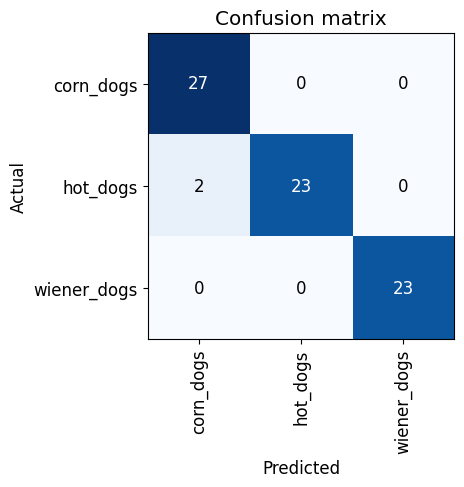

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

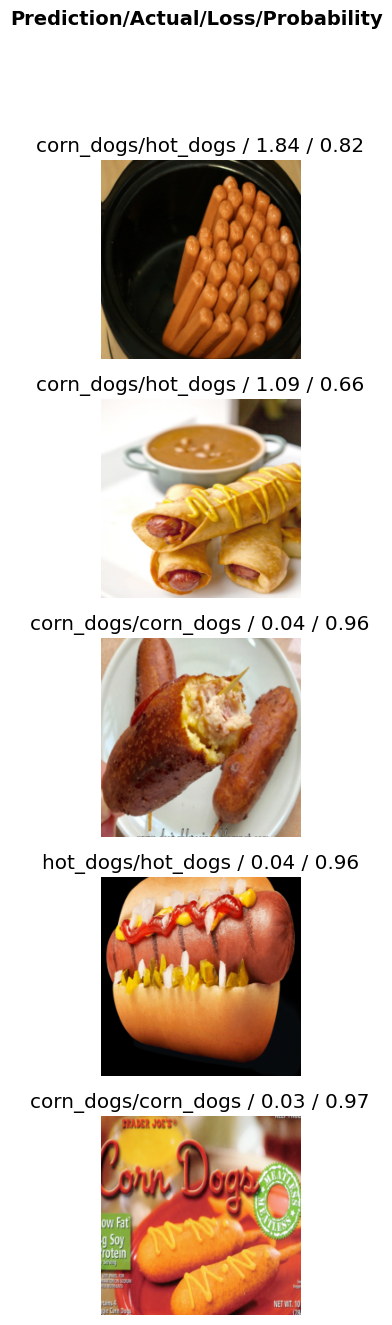

In [20]:
interp.plot_top_losses(5, nrows=5)

## Model is good at differentiating wiener and hot dog, thats for sure

## Export the model and now the result of the work is in the GUI

In [23]:
learn.export()